# MNIST Data Augmentation with Elastic Distortion

In this kernel I'll outline an elastic distortion method for image data augmentation. 
Then I'll visualize elastic distortion and select Keras data augmentations on the MNIST data set.
The data augmentations described in "Good Settings" helped me get 99.7% test accuracy in the [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) competition.

- [Elastic Distortion](#Elastic-Distortion)
    - [Elastic Distortion Function](#Elastic-Distortion-Function)
    - [Use Elastic Distortion with Keras](#Use-Elastic-Distortion-with-Keras)
- [MNIST Visualizations](#MNIST-Visualizations)
    - [Elastic Distortion Arguments Comparison](#Elastic-Distortion-Arguments-Comparison)
    - [Interpolation Blur](#Interpolation-Blur)
    - [Good Settings](#Good-Settings)

## Elastic Distortion

Elastic distortion is another method of data augmentation, as opposed to affine distortion which is the method Keras uses. Elastic distortion does a good job of mimicking variations in human hand writing. A method for applying elastic distortion to the MNIST data set is described by Simard, Steinkraus, and Plattin (2003) in ["Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis"](https://www.microsoft.com/en-us/research/wp-content/uploads/2003/08/icdar03.pdf).

The method outline:
1. Create random displacement fields for height and width, with values randomly sampled from $\mathrm{unif}(-1,1)$. A displacement field defines a direction and magnitude to move a pixel. 
2. Smooth the fields with a gaussian filter. Since $\mu = 0$ for $\mathrm{unif}(-1,1)$, most values will be close to $0$ after the gaussian filter is applied. Thus most of the changes made by the fields will be small (assuming the gaussian filter's sigma value is large enough).
3. Multiply the fields by a scaling factor to control intensity of the deformations.
4. Use interpolation to apply the displacement fields to the image.

#### Elastic Distortion Function

Credit to the following gists for the basic function:
- https://gist.github.com/fmder/e28813c1e8721830ff9c
- https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
- https://gist.github.com/erniejunior/601cdf56d2b424757de5

In [1]:
import numpy as np

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
   # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """
    
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

#### Use Elastic Distortion with Keras

Note that you can pass `elastic_transform()` to a Keras `ImageDataGenerator()` with

    preprocessing_function=lambda x: elastic_transform(x, alpha_range=alpha_range, sigma=sigma).

## MNIST Visualizations

In [2]:
%matplotlib inline

import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


Load MNIST data set.

In [3]:
x_train = np.loadtxt('../input/train.csv', dtype=int, delimiter=',', skiprows=1)
x_train = np.reshape(x_train[:, 1:], (42000, 28, 28))

Define plotting functions.

In [4]:
def plot_digits(examples, title=None, size_mult=1):
    """Intended for graphing MNIST digits. 
    
    # Arguments
        examples: Numpy array with shape (num_examples, height, width, num_iterations).
        title: Plot title string.
        size_mult: Multiply figsize by `size_mult`.
    """
   
    num_iterations = examples.shape[-1]
    num_examples = examples.shape[0]    
    
    plt.rcParams['figure.figsize'] = (num_examples * size_mult, num_iterations * size_mult)
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    
    for c in range(num_iterations):
        for i, ex in enumerate(examples):
            plt.subplot(num_iterations, num_examples, num_examples * c + i + 1)            
            plt.imshow(ex[:,:,c])  
            plt.axis('off')
            if c == 0 and i == 0 and title is not None:
                # only way I found to keep title placement 
                # semi-consistent for different channel counts
                plt.text(
                    x=0,
                    y=-ex.shape[1] // 4 // size_mult,
                    s=title,
                    fontsize=13,
                    horizontalalignment='left', 
                    verticalalignment='bottom')

    plt.show()
    
    
def plot_augmented(examples, alpha_range=0, sigma=0, 
                   width_shift_range=0, height_shift_range=0, zoom_range=0.0, 
                   iterations=1, title=None, size_mult=1):
    """Plot output after elastic distortion and select Keras data augmentations.
    
    # Arguments
        examples: Numpy array with shape (num_examples, height, width, num_iterations).
        alpha_range, sigma: arguments for `elastic_transform()`.
        width_shift_range, height_shift_range, zoom_range: arguments for Keras `ImageDataGenerator()`.
        iterations: Int, number of times to randomly augment the examples.
        title: Plot title string.
        size_mult: Multiply figsize by `size_mult`.
    """
    
    datagen = keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=width_shift_range, 
        height_shift_range=height_shift_range, 
        zoom_range=zoom_range,  
        preprocessing_function=lambda x: elastic_transform(x, alpha_range=alpha_range, sigma=sigma)
    )
    x = [datagen.flow(examples, shuffle=False).next() for i in range(iterations)]
    x = np.concatenate(x, axis=-1)
    plot_digits(x, title=title, size_mult=size_mult)

### Elastic Distortion Arguments Comparison

Recall that `alpha` controls deformation intensity and `sigma` controls displacement field smoothing. 

- `alpha=8, sigma=2` does not have enough smoothing and you get squiggly lines.

- `alpha=8, sigma=3` is close to human handwriting. 

- `alpha=10, sigma=3` some deformations are exaggerated to the point of not looking human made (you may have to run this cell multiple times to see an example of this happening).

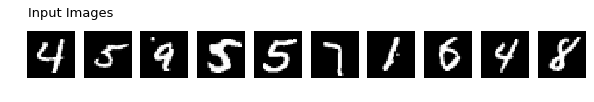

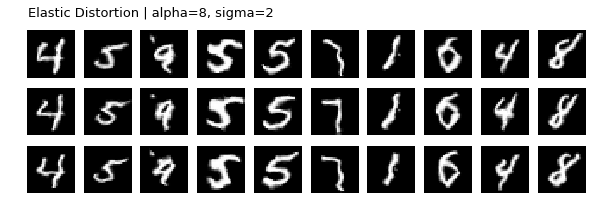

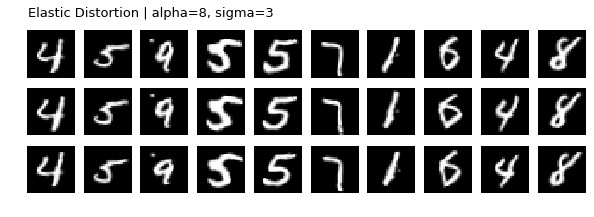

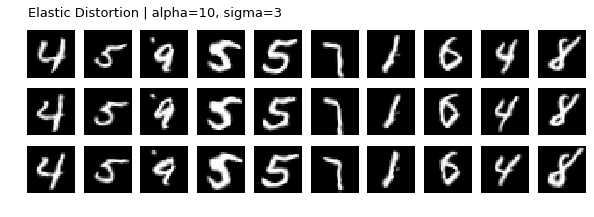

In [5]:
num_examples = 10
ed_examples = np.expand_dims(x_train[np.random.choice(x_train.shape[0], num_examples)], -1)

plot_digits(ed_examples, title='Input Images')

# elastic distortion
plot_augmented(ed_examples, alpha_range=8, sigma=2, 
               iterations=3, title='Elastic Distortion | alpha=8, sigma=2')
plot_augmented(ed_examples, alpha_range=8, sigma=3, 
               iterations=3, title='Elastic Distortion | alpha=8, sigma=3')
plot_augmented(ed_examples, alpha_range=10, sigma=3,
               iterations=3, title='Elastic Distortion | alpha=10, sigma=3')

### Interpolation Blur

When transforming an image, interpolation often needs to approximate pixel values, which has a blurring effect. However, a shift by an exact pixel value does not require any approximation. Keras allows you to do this by passing integer values for the shift arguments. From the Keras [documentation](https://keras.io/preprocessing/image/):
> - int: integer number of pixels from interval `(-width_shift_range, +width_shift_range)`
> - With `width_shift_range=2` possible values are integers `[-1, 0, +1]`, same as with `width_shift_range=[-1, 0, +1]`, while with `width_shift_range=1.0` possible values are floats in the interval `[-1.0, +1.0)`.

It's debatable whether or not blur should be avoided. Below are examples of blur caused by interpolation. Note that the affine transformations done by Keras only use interpolation once after the net result of all the transformations is calculated (for example when using `width_shift_range=1.0` and `zoom_range=0.1` together, the image is still only interpolated once). The `elastic_transform()` function also uses interpolation, which will stack on top of any interpolation Keras does, resulting in exaggerated blurring. So we get the following results:
- Integer shift &rarr; no blur
- Float shift &rarr; some blur
- Elastic distortion and integer shift &rarr; some blur
- Elastic distortion and float shift &rarr; more blur

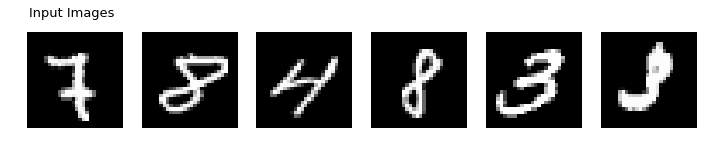

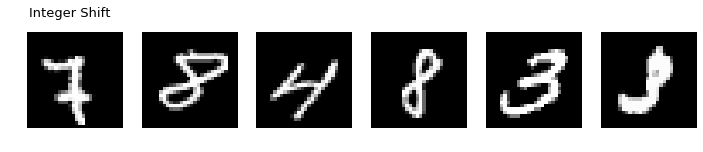

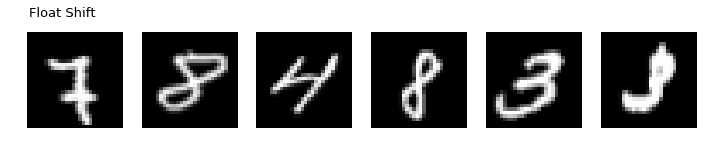

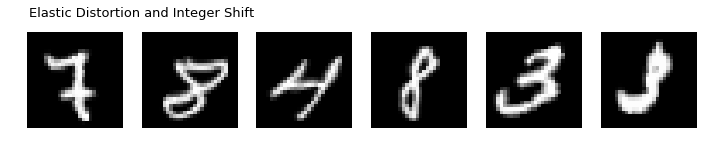

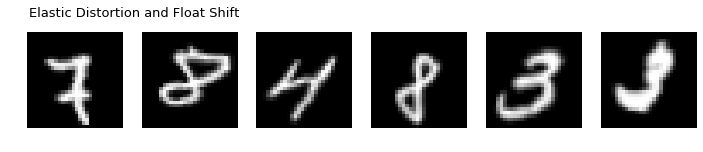

In [6]:
num_examples = 6
b_examples = np.expand_dims(x_train[np.random.choice(x_train.shape[0], num_examples)], -1)

plot_digits(b_examples, title='Input Images', size_mult=2)

# shift
plot_augmented(b_examples, width_shift_range=2, height_shift_range=2,
               title='Integer Shift', size_mult=2)
plot_augmented(b_examples, width_shift_range=1., height_shift_range=1.,
               title='Float Shift', size_mult=2)

# elastic distortion & shift
plot_augmented(b_examples, alpha_range=[8, 10], sigma=3, 
               width_shift_range=2, height_shift_range=2,
               title='Elastic Distortion and Integer Shift', size_mult=2)
plot_augmented(b_examples, alpha_range=[8, 10], sigma=3, 
               width_shift_range=1., height_shift_range=1.,
               title='Elastic Distortion and Float Shift', size_mult=2)

### Good Settings

These are the data augmentation settings I have gotten good results with. Even though `alpha=10` can result in exaggerated writing, I can still tell what the number is supposed to be. Thus, I think exaggerated writing can be useful for training a CNN to recognize what features of the number are most important for identification. By using `alpha_range=[8, 10]`, the CNN will be trained on 'normal' looking numbers as well.

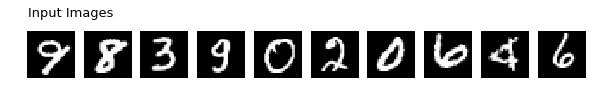

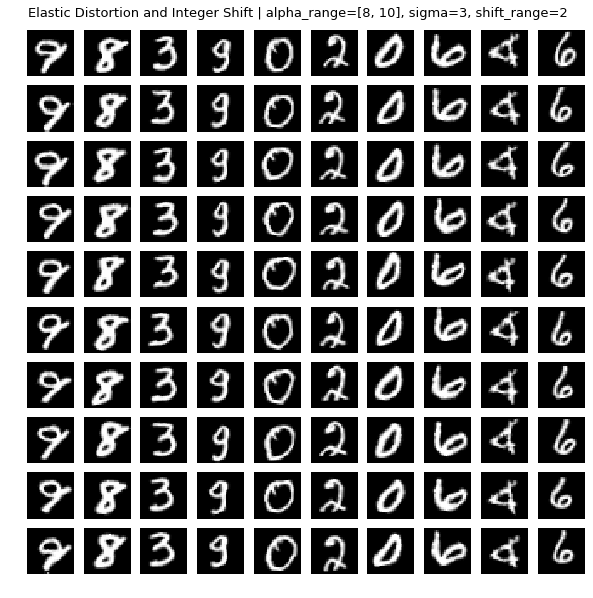

In [7]:
num_examples = 10
examples = np.expand_dims(x_train[np.random.choice(x_train.shape[0], num_examples)], -1)

plot_digits(examples, title='Input Images')

plot_augmented(examples, alpha_range=[8, 10], sigma=3, 
               width_shift_range=2, height_shift_range=2, zoom_range=0, 
               iterations=10, title='Elastic Distortion and Integer Shift | alpha_range=[8, 10], sigma=3, shift_range=2')